In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import plotly.express as px
import math

In [145]:
df = pd.read_csv("../raw_data.csv")
# df = pd.read_csv("../final_dataset.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3305 entries, 0 to 3304
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Ano de Edição  3305 non-null   float64
 1   Colaborador    3305 non-null   object 
 2   Editora        3305 non-null   object 
 3   ISBN           3305 non-null   object 
 4   Ano            3305 non-null   float64
 5   Edição         3305 non-null   float64
 6   Origem         3305 non-null   object 
 7   Formato        3305 non-null   object 
 8   Encadernação   3305 non-null   object 
 9   Idioma         3305 non-null   object 
 10  País           3305 non-null   object 
 11  Páginas        3305 non-null   float64
 12  preço          3305 non-null   float64
 13  nome           3305 non-null   object 
 14  categoria      3305 non-null   object 
dtypes: float64(5), object(10)
memory usage: 387.4+ KB


In [146]:
k = int(1 + 3.3 * math.log10(df.shape[0]))
plt.rcParams["figure.figsize"] = (12, 7)

# Removendo campo não relevantes (identificadores)

In [147]:
df = df.drop(['ISBN'],axis=1)

# Analisando features numéricas

## Correlação entre features numéricas

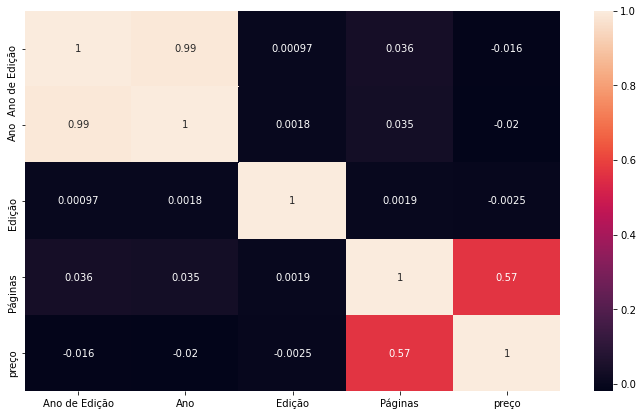

In [148]:
corr = df.corr()
sn.heatmap(corr, annot=True)
plt.show()

### Apenas o número de páginas parece ter uma correlçao positiva relevante

In [149]:
df.describe()

,Ano de Edição,Ano,Edição,Páginas,preço
count,3305.000000,3305.00000,3305.000000,3305.000000,3305.000000
mean,2015.311649,2015.28472,1.737670,287.678971,64.889150
std,6.398325,6.40315,35.069809,250.708627,67.313466
min,1966.000000,1966.00000,1.000000,3.000000,1.710000
25%,2013.000000,2013.00000,1.000000,160.000000,39.000000
50%,2017.000000,2017.00000,1.000000,240.000000,49.900000
75%,2020.000000,2020.00000,1.000000,344.000000,69.900000
max,2021.000000,2021.00000,2015.000000,4032.000000,1551.000000


## Analisando a feature Ano

## Qual a distribuilção dos livros por ano?

In [150]:
cats = ['Medicina','Informática e Tecnologia','Ciências Exatas','Videogames','HQs','Economia','Ciências Biológicas']

In [151]:
fig = px.histogram(df, x="Ano",nbins=k)
fig.show()

In [152]:
ano_dist = df['Ano'].value_counts().reset_index(name='quantidade').sort_values(by='index').rename(columns={'index':'Ano'})
fig = px.line(ano_dist, x="Ano", y="quantidade", title='Livros publicados por ano')
fig.show()

### 2014 teve um boom na publicação de livros, mas no geral, a quantidade de livros publicados parece vir aumentando

In [153]:
ano_cat_dist = df[df['categoria'].isin(cats)].groupby(by=['Ano','categoria']).size().reset_index(name='counts')
fig = px.line(ano_cat_dist, x="Ano", y="counts", color='categoria',title='Quantidade de livros publicados por ano e categoria')
fig.show()

In [154]:
top_5_editoras = list(df['Editora'].value_counts()[1:6].reset_index(name='quatide')['index'])

In [155]:
ano_cat_dist = df[df['Editora'].isin(top_5_editoras)].groupby(by=['Ano','Editora']).size().reset_index(name='counts')
fig = px.line(ano_cat_dist, x="Ano", y="counts", color='Editora',title='Quantidade de livros publicados por ano para as 5 principais editoras')
fig.show()

## Qual o preço médio dos livros pelo anos?

In [156]:
preco_medio_ano = df.groupby(by='Ano')['preço'].mean().reset_index(name='preço médio').rename(columns={'index':'Ano'})
fig = px.line(preco_medio_ano, x="Ano", y="preço médio", title='Preço médio por ano')
fig.show()

### Não parece haver uma tendência

In [157]:
preco_medio_ano = df[df['categoria'].isin(cats)].groupby(by=['Ano','categoria'])['preço'].mean().reset_index(name='preço médio').rename(columns={'index':'Ano'})
fig = px.line(preco_medio_ano, x="Ano", y="preço médio", color='categoria', title='Preço médio por ano e categoria')
fig.show()

# Existe correlação entre os campos categóricos?

In [158]:
df['Editora'].value_counts()

COMPANHIA DAS LETRAS    150
MADRAS                  128
SEXTANTE                111
CONTEXTO                 98
VOZES                    94
                       ... 
SCIPIONE                  1
ANFITEATRO                1
ARTHA EDITORA             1
DC COMICS                 1
SEMENTE                   1
Name: Editora, Length: 323, dtype: int64